## Import required libraries

In [2]:
import os, fnmatch
from math import ceil
import imageio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
from urllib.error import HTTPError
from urllib.request import urlretrieve
from datetime import datetime
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Model, Sequential
from keras.utils import np_utils, plot_model, to_categorical
from keras.layers import Maximum, ZeroPadding2D, BatchNormalization
from keras.layers import Input, Dense, Flatten, Activation, Dropout
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard
from keras.optimizers import Adam, SGD
from keras import optimizers, regularizers
from keras import backend as K

from keras.initializers import glorot_uniform

from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU, ReLU

from keras import applications
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [3]:
from cnn_model_helper import *

## Splitting images to train, validation and test folders

In [5]:
baseFolder = "/home/jupyter/glcapstone"
inputFileFolder = os.path.join(baseFolder, "TrainTestImages")
targetFileFolder = os.path.join(baseFolder, "images")

print(baseFolder)
print(inputFileFolder)
print(targetFileFolder)

/home/jupyter/glcapstone
/home/jupyter/glcapstone/TrainTestImages
/home/jupyter/glcapstone/images


In [6]:
## Only run if folders are already not created with required images
#SplitImagesToTrainTestFolders(inputFileFolder, targetFileFolder)

### Set variables for further use

In [7]:
# Set the path from where images needs to be read
inputFileFolder = os.path.join(baseFolder, "images")
trainFolder = os.path.join(inputFileFolder,"Train")
validationFolder = os.path.join(inputFileFolder,"Validation")
testFolder = os.path.join(inputFileFolder,"Test")
logFolders = os.path.join(baseFolder,"Logs")

print('Images Base Folder: %s' %(inputFileFolder))
print('Train Images Folder: %s' %(trainFolder))
print('Validation Images Folder: %s' %(validationFolder))
print('Test Images Folder: %s' %(testFolder))
print('Log Images Folder: %s' %(logFolders))

Images Base Folder: /home/jupyter/glcapstone/images
Train Images Folder: /home/jupyter/glcapstone/images/Train
Validation Images Folder: /home/jupyter/glcapstone/images/Validation
Test Images Folder: /home/jupyter/glcapstone/images/Test
Log Images Folder: /home/jupyter/glcapstone/Logs


## Create and run model

### Create various generators to read the images

In [8]:
epochs_count = 100
train_batch_size = 32
validation_batch_size = 32

In [9]:
trainDataGen = ImageDataGenerator(
    rescale=1./255
#    , rotation_range=15
#    , width_shift_range=0.3
#    , height_shift_range=0.3
#    , horizontal_flip=True
#    , fill_mode='nearest'
)

train_generator = trainDataGen.flow_from_directory(
    trainFolder, color_mode='rgb', class_mode='categorical'
    , batch_size=train_batch_size, shuffle=True, seed=42
)

Found 22000 images belonging to 22 classes.


In [10]:
vaDataGen = ImageDataGenerator(rescale=1./255)

validation_generator = vaDataGen.flow_from_directory(
    validationFolder , color_mode='rgb' , class_mode='categorical'
    , batch_size=validation_batch_size , shuffle=True , seed=42
)

Found 2200 images belonging to 22 classes.


In [11]:
##print(train_generator.class_indices)

## Compute the step sizes
step_size_train = ceil(train_generator.n/train_generator.batch_size)
step_size_valid = ceil(validation_generator.n/validation_generator.batch_size)

print("Train Step Size: %s" %(step_size_train))
print("Validation Step Size: %s" %(step_size_valid))


Train Step Size: 688
Validation Step Size: 69


In [12]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = "7Layer_4Conv_3Dense_BN_" + timestamp

csvLoggerPath = os.path.join(logFolders, "CSVLogs", '%s.csv' %model_name)
tensorBoardLogPath = os.path.join(logFolders, 'TensorBoardLogs', model_name)
checkPointerPath = os.path.join(logFolders,'CheckPoint', '%s.hdf5' %'7Layer_4Conv_3Dense_BN_20190223-114737')
modelLoc = os.path.join(baseFolder,"Models", "%s.h5" %(model_name))

print("CSV: %s" %(csvLoggerPath))
print("Tensor Board: %s" %(tensorBoardLogPath))
print("Checkpoint: %s" %(checkPointerPath))
print("Model Loc: %s" %(modelLoc))

CSV: /home/jupyter/glcapstone/Logs/CSVLogs/7Layer_4Conv_3Dense_BN_20190307-015123.csv
Tensor Board: /home/jupyter/glcapstone/Logs/TensorBoardLogs/7Layer_4Conv_3Dense_BN_20190307-015123
Checkpoint: /home/jupyter/glcapstone/Logs/CheckPoint/7Layer_4Conv_3Dense_BN_20190223-114737.hdf5
Model Loc: /home/jupyter/glcapstone/Models/7Layer_4Conv_3Dense_BN_20190307-015123.h5


In [13]:
csvLogger = CSVLogger(csvLoggerPath)
checkPointer = ModelCheckpoint(filepath=checkPointerPath,monitor='val_acc', mode='max', verbose=0, save_best_only=True)
tensorBoard = TensorBoard(log_dir=tensorBoardLogPath, batch_size=32, write_graph=True, write_images=True)


#tensorBoard = TensorBoard(log_dir=tensorBoardLogPath, histogram_freq=0, batch_size=32,
#                          write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, 
#                          embeddings_layer_names=None, embeddings_metadata=None, 
#                          embeddings_data=None, update_freq='epoch')

### Create and file Model

In [14]:
classes = len(list(train_generator.class_indices.keys()))

In [15]:
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model = get7Layer_4Conv_3Dense_BN_Model(classes, 'adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
BLOCK1_CONV1_LYR (Conv2D)    (None, 256, 256, 32)      896       
_________________________________________________________________
BLOCK1_BN1_LYR (BatchNormali (None, 256, 256, 32)      128       
_________________________________________________________________
BLOCK1_POOL1_LYR (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
BLOCK2_CONV1_LYR (Conv2D)    (None, 128, 128, 64)      18496     
_________________________________________________________________
BLOCK2_BN1_LYR (BatchNormali (None, 128, 128, 64)      256       
_________________________________________________________________
BLOCK2_POOL1_LYR (MaxPooling (None, 64, 64, 64)        0         
__________

In [ ]:
## Call fit method
# history = model.fit_generator(
#     train_generator
#     , epochs=epochs_count
#     , steps_per_epoch=step_size_train
#     , validation_data=validation_generator
#     , validation_steps= step_size_valid
#     , callbacks=[csvLogger, tensorBoard, checkPointer]
# )

Epoch 1/100
688/688 [==============================] - 162s 236ms/step - loss: 2.3288 - acc: 0.3373 - val_loss: 1.6242 - val_acc: 0.5182
Epoch 2/100
688/688 [==============================] - 156s 227ms/step - loss: 1.3532 - acc: 0.5841 - val_loss: 1.3618 - val_acc: 0.5927
Epoch 3/100
688/688 [==============================] - 156s 227ms/step - loss: 0.9531 - acc: 0.7036 - val_loss: 1.0049 - val_acc: 0.6927
Epoch 4/100
688/688 [==============================] - 156s 227ms/step - loss: 0.6665 - acc: 0.7871 - val_loss: 1.1699 - val_acc: 0.6705
Epoch 5/100
688/688 [==============================] - 156s 226ms/step - loss: 0.4464 - acc: 0.8581 - val_loss: 0.8418 - val_acc: 0.7618
Epoch 6/100
688/688 [==============================] - 156s 227ms/step - loss: 0.2931 - acc: 0.9058 - val_loss: 1.0316 - val_acc: 0.7159
Epoch 7/100
688/688 [==============================] - 156s 227ms/step - loss: 0.2244 - acc: 0.9260 - val_loss: 0.9534 - val_acc: 0.7523
Epoch 8/100
688/688 [====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



688/688 [==============================] - 159s 230ms/step - loss: 0.0097 - acc: 0.9965 - val_loss: 1.4365 - val_acc: 0.7850
Epoch 98/100
688/688 [==============================] - 158s 230ms/step - loss: 0.0153 - acc: 0.9955 - val_loss: 1.4051 - val_acc: 0.7791
Epoch 99/100
502/688 [====================>.........] - ETA: 41s - loss: 0.0107 - acc: 0.9966

### Save model

In [ ]:
# print(modelLoc)
# model.save(modelLoc)

In [21]:
from keras.models import load_model
model = load_model('Logs/CheckPoint/7Layer_4Conv_3Dense_BN_20190223-114737.hdf5')

### Plot train and validation matrix

In [22]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


## Training v/s validation data loss graph

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# r is for "solid red line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

In [ ]:
## Training v/s validation data accuracy graph

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Predict outcome using validation data to create confusion matrix

In [24]:
from keras.models import load_model

# deletes the existing model
#del model  

# returns a compiled model
# identical to the previous one
model = load_model('Logs/CheckPoint/7Layer_4Conv_3Dense_BN_20190223-114737.hdf5')

In [25]:
validation_generator = vaDataGen.flow_from_directory(
    validationFolder
    , color_mode='rgb'
    , class_mode=None
    , batch_size=1
    , shuffle=False
    , seed=42
)

Found 2200 images belonging to 22 classes.


In [26]:
validation_generator.reset()
pred = model.predict_generator(validation_generator, validation_generator.n, verbose=1)

2200/2200 [==============================] - 38s 17ms/step


In [27]:
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

[ 0  0  0 ... 21 21 21]


In [28]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [29]:
filenames=validation_generator.filenames
actualClassIndex = validation_generator.classes
#filePath = validation_generator.filepaths
actualClass = [labels[k] for k in actualClassIndex]

results=pd.DataFrame({
    "Filename":filenames
    , "Predictions":predictions
    , "Actual":actualClass
})

#results

In [30]:
y_actual = validation_generator.classes
y_pred = predicted_class_indices
metrics.accuracy_score(y_actual, y_pred)

0.7886363636363637

             precision    recall  f1-score   support

          0       0.82      0.76      0.79       100
          1       0.89      0.84      0.87       100
          2       0.67      0.55      0.60       100
          3       0.68      0.79      0.73       100
          4       0.77      0.84      0.80       100
          5       0.91      0.84      0.87       100
          6       0.67      0.68      0.67       100
          7       0.62      0.58      0.60       100
          8       0.71      0.87      0.78       100
          9       0.78      0.68      0.73       100
         10       0.72      0.74      0.73       100
         11       0.84      0.84      0.84       100
         12       0.80      0.85      0.83       100
         13       0.77      0.65      0.71       100
         14       0.82      0.91      0.86       100
         15       0.80      0.78      0.79       100
         16       0.84      0.79      0.81       100
         17       0.89      0.91      0.90   

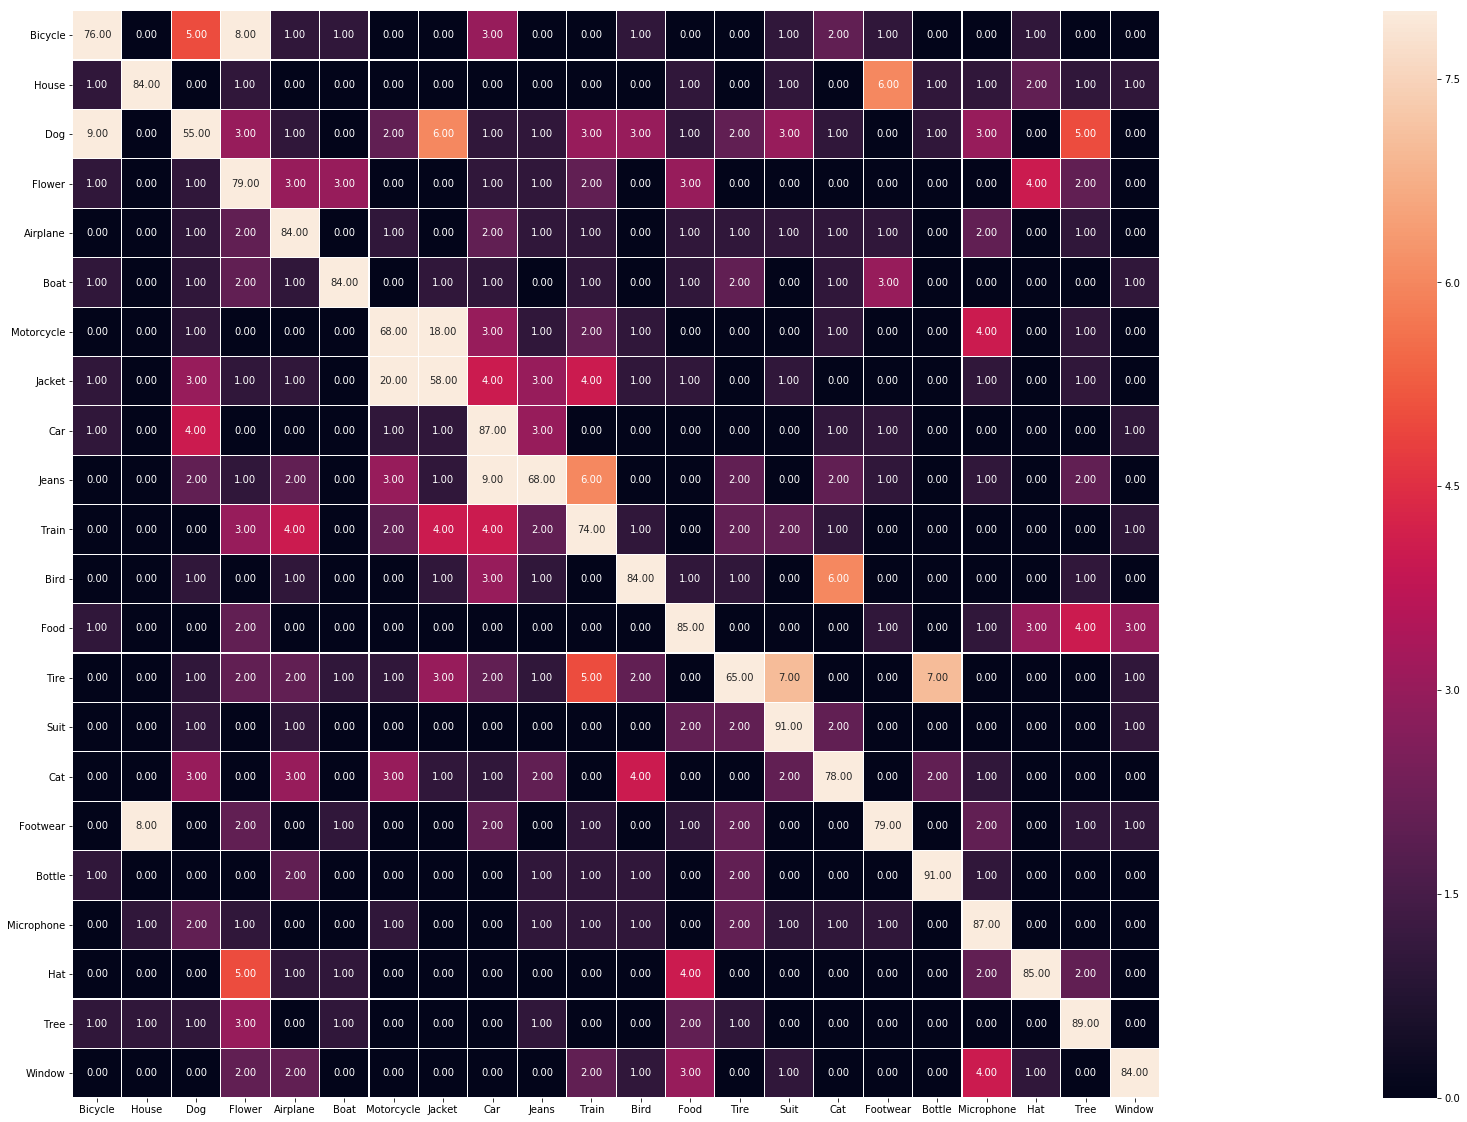

In [31]:
createConfusionMatrix(y_actual, y_pred, train_generator.class_indices.keys())

## Read the saved model based on checkpointing and then validate it on test data

In [32]:
from keras.models import load_model

# deletes the existing model
del model  

# returns a compiled model
# identical to the previous one
model = load_model('Logs/CheckPoint/7Layer_4Conv_3Dense_BN_20190223-114737.hdf5')

### Predict outcome using test data to create confusion matrix

In [33]:
testDataGen = ImageDataGenerator(
    rescale=1./255
)

test_generator = testDataGen.flow_from_directory(
    testFolder
    , color_mode='rgb'
    , class_mode=None
    , batch_size=1
    , shuffle=False
    , seed=42
)

Found 440 images belonging to 22 classes.


In [34]:
test_generator.reset()
pred = model.predict_generator(test_generator, test_generator.n, verbose=1)

440/440 [==============================] - 5s 12ms/step


In [35]:
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

[ 0  5  0 20  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  5  1  1  1  1
 16  1  1 19  1  1  1  3  1  1  1  1  2  1  1  1  2  2  0  7 15  2  2  0
  2  2  2  2 13  2  2  2  7  2  2  2  3  3  3  3 12  3  0  3  3  3 12  3
  3  3  3  3  3  3 12  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4 15  4  4  5  5  5  5  5  5  5 16  5  5  5  5 19  5  5  5  5  5  3  5
  6  6  6  2  6  6  7  6 10  6  6  7  6 10  6  6  6  6  6  6  6  7  7  7
 20 17  7  6  7  7  0  7  7  7  6  6  6  2  6  7  8  8  8  8  8  8  8  8
  9  9  8  8  8  8  8  8 20  8  8  8  9  9  9 20  9  9  6 12  9 10  9  9
  4  9  9  4  9 10 13  9 10  0 10  2 10 18 10 10  6 10 10 10 10 10 15  2
 10 10  6 10 11  6 11 11 11 10 12 11 11 17 11  8 11 11 11 11 11 11 11 11
 12 12 12 20 12 12 12 12 12 12 12 20 12 12 12 12 12 12 12 12 17 13 13 17
 13  8 13 13 13 13 13 13  8  4 17 13 13  7 13 13 14 14 10 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15  6  2 15 15 15 16 16 16 16 16 16 16  1 16

In [36]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [37]:
filenames=test_generator.filenames
actualClassIndex = test_generator.classes
#filePath = validation_generator.filepaths
actualClass = [labels[k] for k in actualClassIndex]

results=pd.DataFrame({
    "Filename":filenames
    , "Predictions":predictions
    , "Actual":actualClass
})

#results

In [38]:
y_actual = validation_generator.classes
y_pred = predicted_class_indices
metrics.accuracy_score(y_actual, y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [2200, 440]

In [ ]:
createConfusionMatrix(y_actual, y_pred, train_generator.class_indices.keys())